In [1]:
!CUDA_VISIBLE_DEVICES=6 torchrun --nproc_per_node=1 module10/run-ablation-study.py

Loading pre-mapped weights from ./pretrained_models/timm_swin_with_gdino_weights.pth
Starting experiment: baseline
Description: Full model with all components
Experiment: baseline, Epoch: 1 Train loss: 28.727 Val loss: 9.905 Train MAE: 51.987 Val MAE: 26.513 Epoch time: 242.700 seconds best
Experiment: baseline, Epoch: 2 Train loss: 26.730 Val loss: 9.514 Train MAE: 41.406 Val MAE: 26.849 Epoch time: 246.632 seconds 
Experiment: baseline, Epoch: 3 Train loss: 26.372 Val loss: 9.047 Train MAE: 35.562 Val MAE: 27.564 Epoch time: 245.849 seconds 
Experiment: baseline, Epoch: 4 Train loss: 23.489 Val loss: 9.016 Train MAE: 27.119 Val MAE: 31.541 Epoch time: 244.549 seconds 
Experiment: baseline, Epoch: 5 Train loss: 21.715 Val loss: 8.390 Train MAE: 26.079 Val MAE: 21.324 Epoch time: 246.505 seconds best
Experiment: baseline, Epoch: 6 Train loss: 21.263 Val loss: 8.643 Train MAE: 26.358 Val MAE: 21.998 Epoch time: 245.934 seconds 
Experiment: baseline, Epoch: 7 Train loss: 20.550 Val loss:

In [2]:
import os
import json
import glob

# Tentukan path ke direktori hasil ablation study
results_dir = "/home/renaldy_fredyan/PhDResearch/ELS/checkpoints/ablation_results"  # Sesuaikan dengan path Anda

# Kumpulkan semua hasil yang tersedia
all_results = {}
baseline_mae = None

# Cari semua file results.json di subdirektori
for result_file in glob.glob(os.path.join(results_dir, "*/results.json")):
    experiment_name = os.path.basename(os.path.dirname(result_file))
    
    with open(result_file, 'r') as f:
        result_data = json.load(f)
        all_results[experiment_name] = result_data
        
        # Simpan baseline MAE jika ini eksperimen baseline
        if experiment_name == "baseline":
            baseline_mae = result_data["test_mae"]

# Hitung relative improvement jika baseline ditemukan
if baseline_mae is not None:
    for name, result in all_results.items():
        if name != "baseline":
            rel_improvement = ((baseline_mae - result["test_mae"]) / baseline_mae) * 100
            all_results[name]["relative_improvement"] = rel_improvement
else:
    print("Warning: Baseline experiment not found. Cannot calculate relative improvements.")

# Buat ringkasan
summary = {
    "experiments": all_results,
    "baseline": all_results.get("baseline")
}

# Simpan ringkasan
summary_path = os.path.join(results_dir, "manual_ablation_summary.json")
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

# Tampilkan tabel ringkasan
print("\n" + "="*80)
print("ABLATION STUDY SUMMARY")
print("="*80)
print(f"{'Experiment':<30} {'Description':<30} {'Test MAE':<10} {'Test RMSE':<10} {'Rel. Imp.%':<10}")
print("-"*80)

for name, result in sorted(all_results.items(), key=lambda x: x[1]["test_mae"]):
    rel_imp = result.get("relative_improvement", "N/A")
    rel_imp_str = f"{rel_imp:.2f}" if isinstance(rel_imp, float) else rel_imp
    
    print(f"{name:<30} {result['description'][:30]:<30} {result['test_mae']:<10.3f} {result['test_rmse']:<10.3f} {rel_imp_str:<10}")

print("="*80)


ABLATION STUDY SUMMARY
Experiment                     Description                    Test MAE   Test RMSE  Rel. Imp.%
--------------------------------------------------------------------------------
one_encoder_layer              One hybrid encoder layer       12.804     72.909     20.05     
five_encoder_layers            Five hybrid encoder layers     12.990     71.134     18.89     
five_iefl_steps                Five iEFL iterative steps      13.294     71.547     16.99     
backbone_trainable             Trainable backbone weights     13.994     87.049     12.62     
large_emb_dim                  Larger embedding dimension (51 14.057     85.206     12.23     
many_heads                     More attention heads (16)      14.078     89.114     12.10     
small_kernel                   Smaller kernel dimension (1x1) 14.293     78.917     10.75     
few_heads                      Fewer attention heads (4)      14.345     68.689     10.43     
large_kernel                   Larger ke

In [3]:
!NCCL_DEBUG=INFO CUDA_VISIBLE_DEVICES=4,5,6,7 torchrun --nproc_per_node=4 module10/test_nccl.py

W0314 14:52:30.842000 265890 site-packages/torch/distributed/run.py:793] 
W0314 14:52:30.842000 265890 site-packages/torch/distributed/run.py:793] *****************************************
W0314 14:52:30.842000 265890 site-packages/torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0314 14:52:30.842000 265890 site-packages/torch/distributed/run.py:793] *****************************************
Rank 0: Tensor awal = tensor([0.], device='cuda:0')
viplab-G481-H81-00:265906:265906 [0] NCCL INFO Bootstrap : Using eno1:140.118.125.208<0>
viplab-G481-H81-00:265906:265906 [0] NCCL INFO NET/Plugin: No plugin found (libnccl-net.so)
viplab-G481-H81-00:265906:265906 [0] NCCL INFO NET/Plugin: Plugin load returned 2 : libnccl-net.so: cannot open shared object file: No such file or directory : when loading libnccl

In [4]:
!CUDA_VISIBLE_DEVICES=6,7 torchrun --nproc_per_node=2 module10/train.py --lr=1e-4 --backbone_lr=0 \
--num_enc_layers=1 \
--model_name=efficient16_freeze_gd --epochs=500 --pre_norm


W0318 10:49:26.259000 3047301 site-packages/torch/distributed/run.py:793] 
W0318 10:49:26.259000 3047301 site-packages/torch/distributed/run.py:793] *****************************************
W0318 10:49:26.259000 3047301 site-packages/torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0318 10:49:26.259000 3047301 site-packages/torch/distributed/run.py:793] *****************************************
Loading pre-mapped weights from ./pretrained_models/timm_swin_with_gdino_weights.pth
Loading pre-mapped weights from ./pretrained_models/timm_swin_with_gdino_weights.pth
0
1
Epoch: 1 Train loss: 15.782 Aux train loss: 9.445 Val loss: 6.198 Aux val loss: 3.737 Train MAE: 56.504 Val MAE: 31.211 Epoch time: 123.812 seconds best
Epoch: 2 Train loss: 15.127 Aux train loss: 9.115 Val loss: 6.081 Aux val loss: 3.

In [6]:
!CUDA_VISIBLE_DEVICES=7 torchrun --nproc_per_node=1 module10/evaluate.py --lr=1e-4 --backbone_lr=0 \
--num_enc_layers=1 \
--model_name=efficient16_freeze_gd --epochs=500 --pre_norm


Loading pre-mapped weights from ./pretrained_models/timm_swin_with_gdino_weights.pth
Val set MAE: 11.16 RMSE: 31.67
GT count: tensor([30.,  8.], device='cuda:0')
Predicted count: tensor([23.5119,  9.3422], device='cuda:0')
Test set MAE: 12.79 RMSE: 92.61
GT count: tensor([17., 34.], device='cuda:0')
Predicted count: tensor([20.1476, 26.1781], device='cuda:0')



5 Best MAE:
Train MAE:
Epoch     MAE            
-------------------------
410       4.4223         
447       4.4363         
437       4.4386         
469       4.4913         
495       4.4959         

Validation MAE:
Epoch     MAE            
-------------------------
177       11.1600        
384       12.0565        
300       12.3530        
306       12.3753        
366       12.4517        


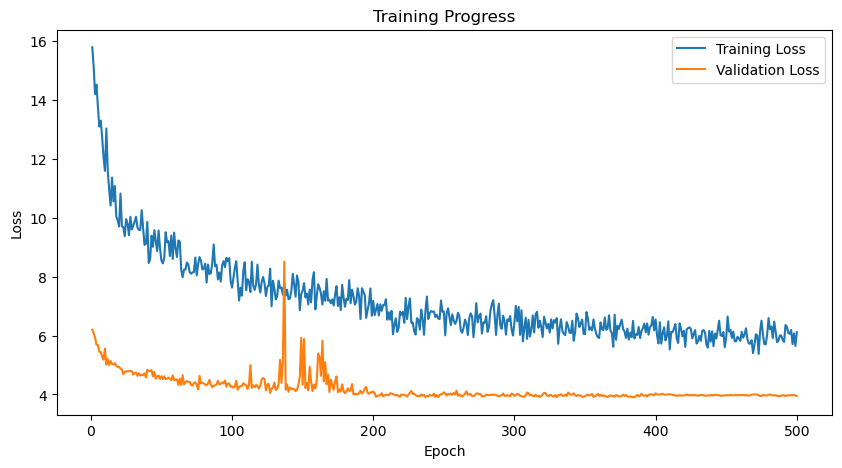

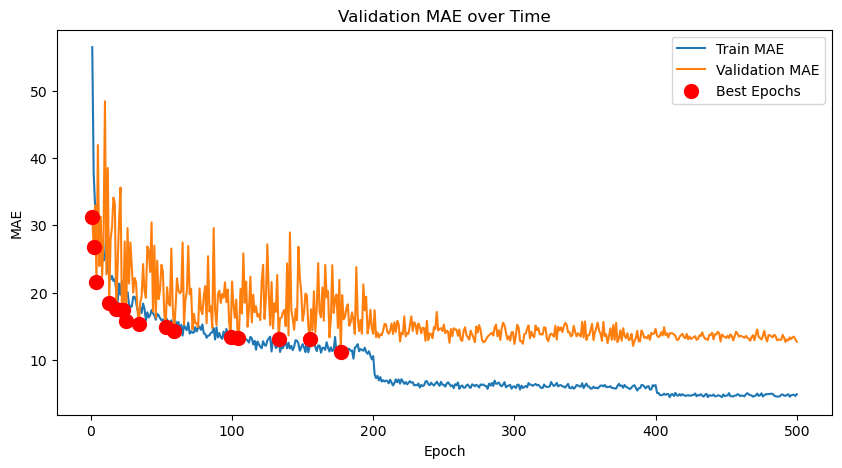

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Baca CSV
df = pd.read_csv('checkpoints/efficient16_freeze_gd.csv')

# df['Validation MAE'] = df['Validation MAE'] / 8

best_train = df.nsmallest(5, 'Train MAE')[['Epoch', 'Train MAE']]
best_val = df.nsmallest(5, 'Validation MAE')[['Epoch', 'Validation MAE']]


# Print tabel
print("\n5 Best MAE:")
print("=" * 50)
print("Train MAE:")
print(f"{'Epoch':<10}{'MAE':<15}")
print("-" * 25)
for _, row in best_train.iterrows():
    print(f"{int(row['Epoch']):<10}{row['Train MAE']:<15.4f}")

print("\nValidation MAE:")
print(f"{'Epoch':<10}{'MAE':<15}")
print("-" * 25)
for _, row in best_val.iterrows():
    print(f"{int(row['Epoch']):<10}{row['Validation MAE']:<15.4f}")
print("=" * 50)

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'], df['Training Loss'], label='Training Loss')
plt.plot(df['Epoch'], df['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')
plt.show()

# Plot MAE dengan best points
plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'], df['Train MAE'], label='Train MAE')
plt.plot(df['Epoch'], df['Validation MAE'], label='Validation MAE')

# Tambahkan titik merah untuk Best Epochs
best_epochs = df[df['Best Epoch'] == 'Yes']
plt.scatter(best_epochs['Epoch'], best_epochs['Validation MAE'], 
           color='red', s=100, label='Best Epochs', zorder=5)

plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Validation MAE over Time')
plt.show()